In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
import os
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
from src.metrics import metrics
from src.data_manage import get_all_labels

In [3]:
labels_dataset = get_all_labels()

In [4]:
pattern_params = r'([a-z_]+)=([0-9a-zA-Z]+)'

def calcmetricsfrompath(path, include_cls_params=True):

    splitted = os.path.normpath(path).split(os.sep)
    *_, cls_folder, dataset_folder, csv_file = splitted

    cls_params = dict( re.findall(pattern_params, cls_folder) )
    if not include_cls_params:
        cls_params = {'cls' : cls_params['cls'] }
    dataset_params = dict( re.findall(pattern_params, dataset_folder) )
    csv_params = dict( re.findall(pattern_params, csv_file) )

    scores=pd.read_csv(path, header=None, index_col=0)
    scores.dropna(inplace=True)

    labels=labels_dataset[dataset_params["dataset"]].loc[scores.index]
    preds=scores.map(lambda x: 0 if x<.5 else 1)

    metrics_results = {metricName:metricFnc(labels, preds, scores) for metricName, metricFnc in metrics.items()}

    row_dataframe = pd.DataFrame( [metrics_results|cls_params|dataset_params|csv_params] )

    return row_dataframe

# Metrics Dataframe

In [5]:
from src.paths import DIR_CV
from src.target_configs import DATASET

In [6]:
results=pd.DataFrame()
for dir_cls in os.listdir(DIR_CV):
    if 'RF' in dir_cls and dir_cls!='cls=RF-max_features=sqrt-n_estimators=100':
        continue
    for dir_dataset in os.listdir(os.path.join(DIR_CV, dir_cls)):
        if 'split=-1' in dir_dataset:
            continue
        
        for file_score in os.listdir(os.path.join(DIR_CV, dir_cls, dir_dataset)):
            fullpath=os.path.join(DIR_CV, dir_cls, dir_dataset, file_score)
            
            results=pd.concat([results,calcmetricsfrompath(fullpath, False)],ignore_index=True)

In [7]:
results

,Accuracy,Sensitivity,Specificity,MCC,ppv,npv,ROCcurve,f1,cls,dataset,split,seed,fold
0,0.771721,0.808642,0.726236,0.537120,0.784431,0.754941,0.860436,0.796353,RF,cav,0,0,5
1,0.778535,0.787037,0.768061,0.553722,0.806962,0.745387,0.866069,0.796875,RF,cav,0,1,5
2,0.778535,0.783951,0.771863,0.554158,0.808917,0.743590,0.857127,0.796238,RF,cav,0,2,5
3,0.775128,0.787037,0.760456,0.546436,0.801887,0.743494,0.857156,0.794393,RF,cav,0,3,5
4,0.764906,0.765432,0.764259,0.527657,0.800000,0.725632,0.851136,0.782334,RF,cav,0,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.656203,0.674765,0.637456,0.312453,0.652758,0.659927,0.720235,0.663579,ADA,erg,9,5,5
1496,0.652965,0.656916,0.648973,0.305900,0.653998,0.651911,0.719588,0.655454,ADA,erg,9,6,5
1497,0.650349,0.657660,0.642964,0.300660,0.650405,0.650291,0.717569,0.654012,ADA,erg,9,7,5
1498,0.653214,0.664601,0.641713,0.306401,0.651994,0.654494,0.721612,0.658237,ADA,erg,9,8,5


In [8]:
groupedresults=results.groupby(["dataset", 'cls']).describe()

In [9]:
statsCV=groupedresults.loc[:,(slice(None), ['mean','std'] )]

In [13]:
def as_percent_str(float, digits=1):
    x = round(float, digits+2)
    return format(x*100, f'.{digits}f')# + r'\%'

def as_round_str(float, digits=3):
    x = round(float, digits)
    return format(x, f'.{digits}f')

def process_column(column):
    # column is the first level of a multindexed column
    mean_values = column['mean']
    devstd = column['std']

    return mean_values.apply(as_round_str) + ' ± ' + devstd.apply(as_round_str)# + '%'

In [14]:
statsCV_table = pd.DataFrame(index=statsCV.index)
for column_name in statsCV.columns.get_level_values(0).drop_duplicates():
    statsCV_table[column_name]=process_column(statsCV[column_name])

In [15]:
statsCV_table.loc[DATASET]

Accuracy    Sensitivity    Specificity            MCC  \
dataset cls                                                               
erg     ADA  0.656 ± 0.004  0.664 ± 0.008  0.647 ± 0.008  0.312 ± 0.008   
        KNN  0.741 ± 0.004  0.737 ± 0.006  0.744 ± 0.007  0.482 ± 0.009   
        RF   0.758 ± 0.004  0.746 ± 0.005  0.770 ± 0.005  0.516 ± 0.007   
        SVM  0.723 ± 0.004  0.731 ± 0.005  0.714 ± 0.006  0.445 ± 0.009   
        XGB  0.696 ± 0.003  0.687 ± 0.005  0.705 ± 0.006  0.392 ± 0.007   
nav     ADA  0.754 ± 0.010  0.749 ± 0.015  0.758 ± 0.015  0.507 ± 0.021   
        KNN  0.783 ± 0.011  0.779 ± 0.014  0.786 ± 0.013  0.564 ± 0.022   
        RF   0.799 ± 0.010  0.766 ± 0.013  0.829 ± 0.011  0.596 ± 0.019   
        SVM  0.785 ± 0.010  0.774 ± 0.014  0.795 ± 0.012  0.569 ± 0.021   
        XGB  0.773 ± 0.008  0.721 ± 0.013  0.820 ± 0.012  0.544 ± 0.016   
cav     ADA  0.768 ± 0.014  0.793 ± 0.017  0.738 ± 0.022  0.531 ± 0.029   
        KNN  0.747 ± 0.017  0.810 ± 0.019  0.670 ± 0.027  0.486 ± 0.035   
        RF   0.783 ± 0.013  0.804 ± 0.018  0.758 ± 0.022  0.562 ± 0.027   
        SVM  0.762 ± 0.012  0.797 ± 0.014  0.718 ± 0.021  0.517 ± 0.025   
        XGB  0.795 ± 0.013  0.816 ± 0.016  0.769 ± 0.019  0.585 ± 0.026   

                       ppv            npv       ROCcurve             f1  
dataset cls                                                              
erg     ADA  0.656 ± 0.005  0.656 ± 0.005  0.721 ± 0.004  0.660 ± 0.005  
        KNN  0.744 ± 0.005  0.737 ± 0.005  0.801 ± 0.004  0.741 ± 0.004  
        RF   0.766 ± 0.004  0.750 ± 0.004  0.832 ± 0.003  0.756 ± 0.004  
        SVM  0.721 ± 0.005  0.725 ± 0.005  0.793 ± 0.004  0.726 ± 0.004  
        XGB  0.701 ± 0.004  0.690 ± 0.003  0.772 ± 0.003  0.694 ± 0.003  
nav     ADA  0.735 ± 0.013  0.771 ± 0.011  0.828 ± 0.008  0.742 ± 0.011  
        KNN  0.766 ± 0.013  0.798 ± 0.012  0.842 ± 0.009  0.772 ± 0.012  
        RF   0.800 ± 0.012  0.798 ± 0.010  0.878 ± 0.007  0.783 ± 0.011  
        SVM  0.772 ± 0.011  0.797 ± 0.011  0.851 ± 0.009  0.773 ± 0.011  
        XGB  0.782 ± 0.011  0.766 ± 0.008  0.851 ± 0.006  0.750 ± 0.009  
cav     ADA  0.789 ± 0.015  0.743 ± 0.017  0.833 ± 0.013  0.791 ± 0.013  
        KNN  0.752 ± 0.017  0.741 ± 0.022  0.809 ± 0.015  0.780 ± 0.015  
        RF   0.804 ± 0.015  0.759 ± 0.017  0.861 ± 0.011  0.804 ± 0.012  
        SVM  0.777 ± 0.013  0.742 ± 0.014  0.821 ± 0.012  0.787 ± 0.011  
        XGB  0.813 ± 0.013  0.773 ± 0.016  0.874 ± 0.010  0.815 ± 0.012

In [16]:
statsCV_table.loc[DATASET].to_csv('tables/statsCV.csv')

## CUTOFF

In [17]:
#dataset
#split
#cutoff
cutoff_results = pd.DataFrame()
for dataset in DATASET:
    
    if dataset == 'cav':
        cls = 'XGB'
    else:
        cls = 'RF-max_features=sqrt-n_estimators=100'

    for split in range(10):
        scoresPred=pd.read_csv(f'preds/cls={cls}/dataset={dataset}-split={split}.csv', index_col=0, header=None).squeeze()
        labelTrue=labels_dataset[dataset].loc[scoresPred.index]
        
        for cutoff in np.arange(0.2,0.8,0.1):
            params={'cutoff': cutoff, 'dataset':dataset, 'split':split}
            label_pred = scoresPred.apply(lambda x: 0 if x < cutoff else 1)
            metrics_results = {metricName:metricFnc(labelTrue, label_pred, scoresPred) 
                       for metricName, metricFnc in metrics.items()}
            cutoff_results = pd.concat([cutoff_results, pd.DataFrame([metrics_results | params])], ignore_index=True)
            
    

In [18]:
cutoff_results

,Accuracy,Sensitivity,Specificity,MCC,ppv,npv,ROCcurve,f1,cutoff,dataset,split
0,0.668660,0.939484,0.395395,0.399589,0.610574,0.866228,0.854223,0.740133,0.2,erg,0
1,0.723966,0.879960,0.566567,0.470539,0.671970,0.823872,0.854223,0.762027,0.3,erg,0
2,0.761335,0.827381,0.694695,0.526896,0.732221,0.799539,0.854223,0.776898,0.4,erg,0
3,0.779771,0.766865,0.792793,0.559806,0.788776,0.771178,0.854223,0.777666,0.5,erg,0
4,0.783757,0.694444,0.873874,0.577417,0.847458,0.739204,0.854223,0.763359,0.6,erg,0
...,...,...,...,...,...,...,...,...,...,...,...
205,0.768707,0.864198,0.651515,0.532089,0.752688,0.796296,0.875701,0.804598,0.4,cav,9
206,0.802721,0.814815,0.787879,0.601906,0.825000,0.776119,0.875701,0.819876,0.5,cav,9
207,0.795918,0.728395,0.878788,0.606389,0.880597,0.725000,0.875701,0.797297,0.6,cav,9
208,0.755102,0.604938,0.939394,0.563867,0.924528,0.659574,0.875701,0.731343,0.7,cav,9


In [19]:
cutoff_group = cutoff_results.drop(columns='split').groupby(['dataset','cutoff']).describe().loc[:,(slice(None), ['mean','std'] )]

In [20]:
cutoff_table = pd.DataFrame(index=cutoff_group.index)
for column_name in cutoff_group.columns.get_level_values(0).drop_duplicates():
    cutoff_table[column_name]=process_column(cutoff_group[column_name])

In [21]:
cutoff_table.loc[DATASET]

Accuracy    Sensitivity    Specificity            MCC  \
dataset cutoff                                                               
erg     0.2     0.665 ± 0.008  0.941 ± 0.007  0.386 ± 0.014  0.393 ± 0.018   
        0.3     0.714 ± 0.009  0.878 ± 0.009  0.549 ± 0.019  0.453 ± 0.017   
        0.4     0.749 ± 0.007  0.815 ± 0.010  0.683 ± 0.013  0.503 ± 0.014   
        0.5     0.762 ± 0.009  0.739 ± 0.016  0.785 ± 0.013  0.525 ± 0.018   
        0.6     0.755 ± 0.012  0.648 ± 0.021  0.863 ± 0.011  0.522 ± 0.023   
        0.7     0.728 ± 0.012  0.542 ± 0.019  0.915 ± 0.010  0.492 ± 0.023   
        0.8     0.685 ± 0.009  0.415 ± 0.015  0.957 ± 0.007  0.442 ± 0.018   
nav     0.2     0.702 ± 0.027  0.935 ± 0.013  0.493 ± 0.057  0.471 ± 0.041   
        0.3     0.756 ± 0.030  0.881 ± 0.029  0.644 ± 0.051  0.536 ± 0.055   
        0.4     0.791 ± 0.024  0.830 ± 0.042  0.755 ± 0.041  0.586 ± 0.047   
        0.5     0.803 ± 0.019  0.771 ± 0.053  0.831 ± 0.037  0.606 ± 0.037   
        0.6     0.803 ± 0.026  0.708 ± 0.074  0.887 ± 0.032  0.611 ± 0.046   
        0.7     0.793 ± 0.032  0.638 ± 0.073  0.931 ± 0.021  0.602 ± 0.059   
        0.8     0.773 ± 0.026  0.554 ± 0.062  0.969 ± 0.012  0.584 ± 0.043   
cav     0.2     0.676 ± 0.021  0.959 ± 0.022  0.327 ± 0.054  0.381 ± 0.045   
        0.3     0.744 ± 0.026  0.912 ± 0.029  0.538 ± 0.051  0.494 ± 0.056   
        0.4     0.767 ± 0.029  0.867 ± 0.046  0.645 ± 0.048  0.532 ± 0.062   
        0.5     0.788 ± 0.035  0.814 ± 0.047  0.756 ± 0.041  0.571 ± 0.070   
        0.6     0.797 ± 0.036  0.760 ± 0.052  0.841 ± 0.045  0.600 ± 0.071   
        0.7     0.785 ± 0.044  0.664 ± 0.055  0.933 ± 0.043  0.608 ± 0.086   
        0.8     0.744 ± 0.036  0.562 ± 0.049  0.968 ± 0.035  0.564 ± 0.069   

                          ppv            npv       ROCcurve             f1  
dataset cutoff                                                              
erg     0.2     0.607 ± 0.006  0.866 ± 0.015  0.838 ± 0.008  0.738 ± 0.006  
        0.3     0.663 ± 0.009  0.817 ± 0.011  0.838 ± 0.008  0.755 ± 0.006  
        0.4     0.722 ± 0.008  0.785 ± 0.009  0.838 ± 0.008  0.765 ± 0.007  
        0.5     0.776 ± 0.010  0.749 ± 0.011  0.838 ± 0.008  0.757 ± 0.010  
        0.6     0.826 ± 0.012  0.708 ± 0.013  0.838 ± 0.008  0.726 ± 0.016  
        0.7     0.865 ± 0.015  0.664 ± 0.010  0.838 ± 0.008  0.666 ± 0.017  
        0.8     0.907 ± 0.015  0.619 ± 0.007  0.838 ± 0.008  0.569 ± 0.015  
nav     0.2     0.624 ± 0.024  0.895 ± 0.015  0.886 ± 0.016  0.748 ± 0.016  
        0.3     0.690 ± 0.032  0.858 ± 0.028  0.886 ± 0.016  0.773 ± 0.025  
        0.4     0.753 ± 0.030  0.834 ± 0.031  0.886 ± 0.016  0.789 ± 0.025  
        0.5     0.805 ± 0.029  0.804 ± 0.030  0.886 ± 0.016  0.786 ± 0.027  
        0.6     0.851 ± 0.029  0.775 ± 0.037  0.886 ± 0.016  0.770 ± 0.045  
        0.7     0.893 ± 0.030  0.744 ± 0.036  0.886 ± 0.016  0.742 ± 0.053  
        0.8     0.942 ± 0.019  0.710 ± 0.027  0.886 ± 0.016  0.696 ± 0.049  
cav     0.2     0.637 ± 0.016  0.872 ± 0.050  0.877 ± 0.035  0.765 ± 0.012  
        0.3     0.708 ± 0.022  0.835 ± 0.047  0.877 ± 0.035  0.797 ± 0.019  
        0.4     0.751 ± 0.026  0.801 ± 0.055  0.877 ± 0.035  0.804 ± 0.027  
        0.5     0.804 ± 0.031  0.769 ± 0.045  0.877 ± 0.035  0.808 ± 0.035  
        0.6     0.855 ± 0.039  0.743 ± 0.043  0.877 ± 0.035  0.804 ± 0.038  
        0.7     0.924 ± 0.049  0.695 ± 0.041  0.877 ± 0.035  0.772 ± 0.051  
        0.8     0.956 ± 0.048  0.643 ± 0.029  0.877 ± 0.035  0.707 ± 0.047

In [22]:
test_predictions05_table = cutoff_table.loc[DATASET].query('cutoff > 0.45 and cutoff < 0.55').droplevel(1,axis='index')

In [23]:
test_predictions05_table.to_csv('tables/test_predictions05.csv')

## Cutoff Charts

In [23]:
from src.target_configs import TARGET_NAMES

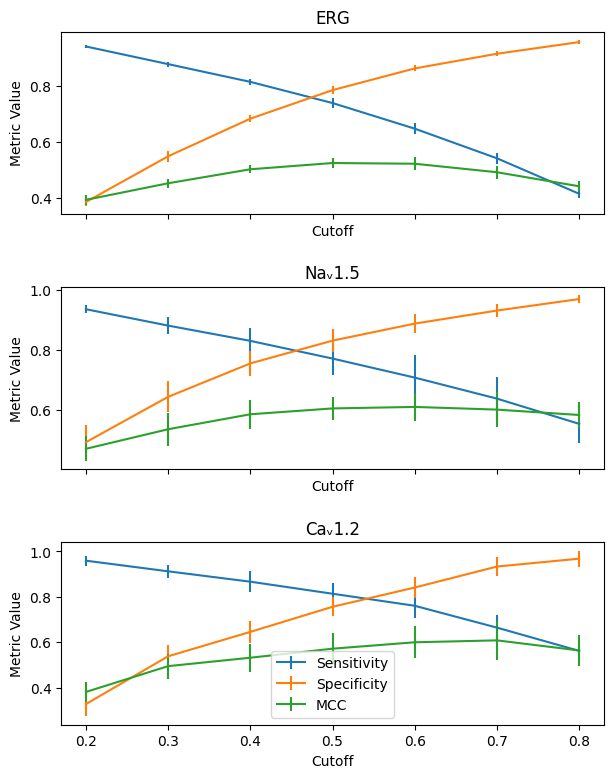

In [24]:
cutoff_metrics = ['Sensitivity','Specificity', 'MCC']

fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(7,9), sharex=True,
                         gridspec_kw={'hspace':0.4})

for target, ax in zip(DATASET, axes.flatten()):
    tmp_df = cutoff_group.loc[target]
    cutoff=tmp_df.index
    ax.set_title(TARGET_NAMES[target])
    ax.set_xlabel('Cutoff')
    ax.set_ylabel('Metric Value')
    for metric in cutoff_metrics:
        mean=tmp_df[(metric,'mean')]
        std=tmp_df[(metric,'std')]
        ax.errorbar(cutoff, mean, yerr=std, label=metric)

ax.legend()

## Boxplot

In [29]:
import seaborn as sns

In [30]:
def plot_boxresults(results_dataset, name_dataset):
    grouped=results_dataset.drop(columns=['fold','seed','split','dataset'])\
    .melt(id_vars='cls', value_vars=list(metrics.keys()))

    fig,ax = plt.subplots(figsize=(12,7))

    n_cls = 5

    sns.boxplot(grouped, x='cls',y='value',hue='variable', ax=ax)
    for i in range(n_cls):
        ax.axvline(i + 0.5, color='black', linestyle='-')
        
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax.set_title(f"{name_dataset}", fontsize=16)

    plt.close(fig)
    return fig

In [31]:
fig_cav = plot_boxresults(results.query('dataset == "cav"'), 'Caᵥ1.2')

In [32]:
fig_cav.savefig('Figures/boxplotCAV.png',bbox_inches="tight")

In [33]:
fig_nav = plot_boxresults(results.query('dataset == "nav"'),'Naᵥ1.5')

In [34]:
fig_nav.savefig('Figures/boxplotNAV.png',bbox_inches="tight")

In [35]:
fig_erg = plot_boxresults(results.query('dataset == "erg"'), 'ERG')

In [36]:
fig_erg.savefig('Figures/boxploterg.png',bbox_inches="tight")

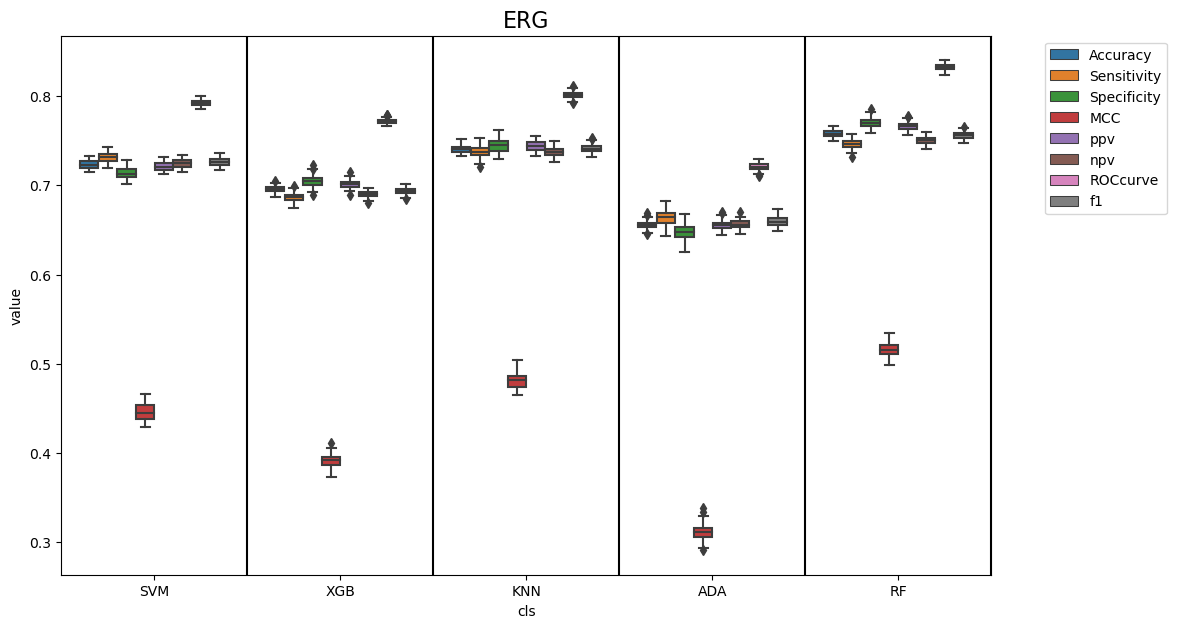

In [37]:
fig_erg

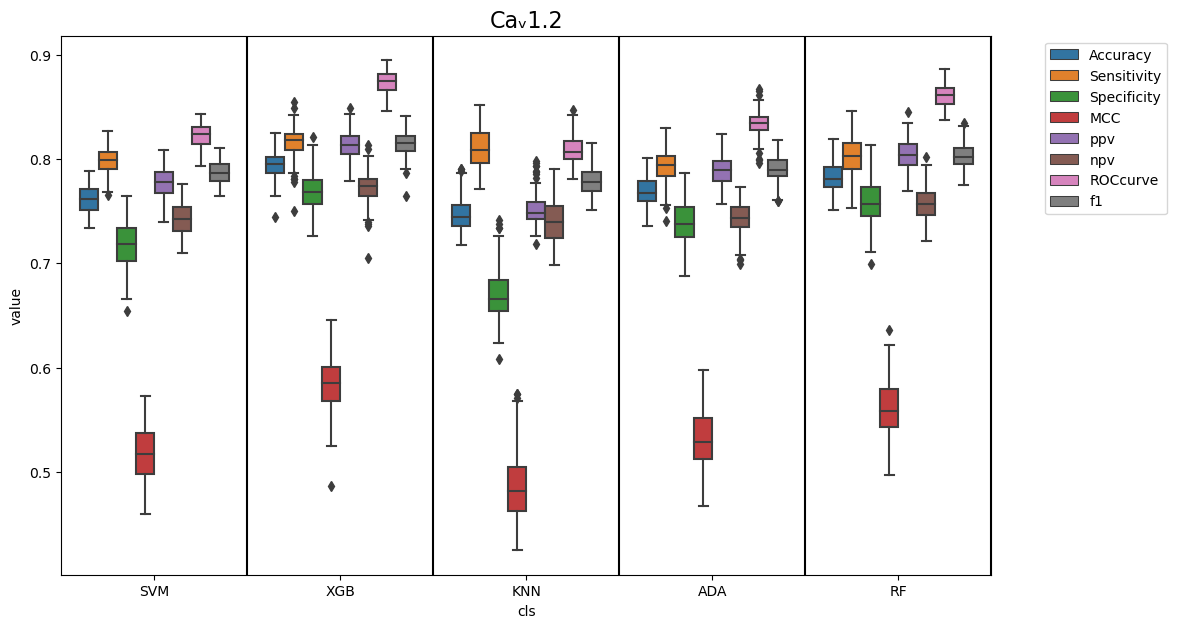

In [38]:
fig_cav

## RF grid

In [24]:
resultsRF=pd.DataFrame()
for dir_cls in os.listdir(DIR_CV):
    if not 'RF' in dir_cls:
        continue
    for dir_dataset in os.listdir(os.path.join(DIR_CV, dir_cls)):
        if 'split=-1' in dir_dataset:
            continue
        
        for file_score in os.listdir(os.path.join(DIR_CV, dir_cls, dir_dataset)):
            fullpath=os.path.join(DIR_CV, dir_cls, dir_dataset, file_score)
            
            resultsRF=pd.concat([resultsRF,calcmetricsfrompath(fullpath, include_cls_params=True)],ignore_index=True)

In [25]:
resultsRF

,Accuracy,Sensitivity,Specificity,MCC,ppv,npv,ROCcurve,f1,cls,max_features,n_estimators,dataset,split,seed,fold
0,0.771721,0.808642,0.726236,0.537120,0.784431,0.754941,0.860436,0.796353,RF,sqrt,100,cav,0,0,5
1,0.778535,0.787037,0.768061,0.553722,0.806962,0.745387,0.866069,0.796875,RF,sqrt,100,cav,0,1,5
2,0.778535,0.783951,0.771863,0.554158,0.808917,0.743590,0.857127,0.796238,RF,sqrt,100,cav,0,2,5
3,0.775128,0.787037,0.760456,0.546436,0.801887,0.743494,0.857156,0.794393,RF,sqrt,100,cav,0,3,5
4,0.764906,0.765432,0.764259,0.527657,0.800000,0.725632,0.851136,0.782334,RF,sqrt,100,cav,0,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.768809,0.749132,0.788683,0.538175,0.781686,0.756848,0.838137,0.765063,RF,50,200,erg,9,5,5
2096,0.759218,0.744175,0.774412,0.518778,0.769152,0.749818,0.832186,0.756457,RF,50,200,erg,9,6,5
2097,0.755605,0.742191,0.769154,0.511491,0.764556,0.747082,0.831566,0.753208,RF,50,200,erg,9,7,5
2098,0.764823,0.749876,0.779920,0.529988,0.774846,0.755335,0.836039,0.762157,RF,50,200,erg,9,8,5


In [26]:
grp_resultsRF=resultsRF.groupby(["dataset", 'max_features', 'n_estimators']).describe()

In [27]:
statsRF=grp_resultsRF.loc[:,(slice(None), ['mean','std'] )]

In [28]:
statsRF_table = pd.DataFrame(index=statsRF.index)
for column_name in statsRF.columns.get_level_values(0).drop_duplicates():
    statsRF_table[column_name]=process_column(statsRF[column_name])

In [29]:
statsRF_table.loc[DATASET]

Accuracy    Sensitivity  \
dataset max_features n_estimators                                 
erg     10           100           0.758 ± 0.004  0.746 ± 0.005   
                     150           0.759 ± 0.004  0.746 ± 0.005   
                     200           0.760 ± 0.004  0.745 ± 0.005   
        50           100           0.758 ± 0.004  0.747 ± 0.005   
                     150           0.759 ± 0.004  0.746 ± 0.005   
                     200           0.760 ± 0.004  0.746 ± 0.006   
        sqrt         100           0.758 ± 0.004  0.746 ± 0.005   
nav     10           100           0.800 ± 0.009  0.768 ± 0.012   
                     150           0.801 ± 0.009  0.766 ± 0.012   
                     200           0.801 ± 0.010  0.767 ± 0.013   
        50           100           0.799 ± 0.010  0.766 ± 0.013   
                     150           0.799 ± 0.010  0.765 ± 0.014   
                     200           0.800 ± 0.010  0.765 ± 0.013   
        sqrt         100           0.799 ± 0.010  0.766 ± 0.013   
cav     10           100           0.783 ± 0.014  0.808 ± 0.019   
                     150           0.784 ± 0.013  0.810 ± 0.018   
                     200           0.784 ± 0.014  0.810 ± 0.019   
        50           100           0.783 ± 0.013  0.803 ± 0.017   
                     150           0.784 ± 0.013  0.804 ± 0.018   
                     200           0.783 ± 0.013  0.803 ± 0.017   
        sqrt         100           0.783 ± 0.013  0.804 ± 0.018   

                                     Specificity            MCC  \
dataset max_features n_estimators                                 
erg     10           100           0.770 ± 0.005  0.516 ± 0.008   
                     150           0.773 ± 0.005  0.519 ± 0.007   
                     200           0.775 ± 0.005  0.520 ± 0.008   
        50           100           0.770 ± 0.005  0.517 ± 0.007   
                     150           0.772 ± 0.005  0.518 ± 0.008   
                     200           0.773 ± 0.005  0.519 ± 0.008   
        sqrt         100           0.770 ± 0.005  0.516 ± 0.007   
nav     10           100           0.829 ± 0.012  0.598 ± 0.019   
                     150           0.832 ± 0.011  0.600 ± 0.019   
                     200           0.832 ± 0.013  0.601 ± 0.021   
        50           100           0.829 ± 0.012  0.597 ± 0.021   
                     150           0.830 ± 0.012  0.597 ± 0.020   
                     200           0.832 ± 0.012  0.599 ± 0.020   
        sqrt         100           0.829 ± 0.011  0.596 ± 0.019   
cav     10           100           0.752 ± 0.022  0.560 ± 0.028   
                     150           0.752 ± 0.022  0.562 ± 0.027   
                     200           0.752 ± 0.022  0.563 ± 0.028   
        50           100           0.758 ± 0.019  0.561 ± 0.026   
                     150           0.759 ± 0.019  0.563 ± 0.025   
                     200           0.759 ± 0.020  0.561 ± 0.027   
        sqrt         100           0.758 ± 0.022  0.562 ± 0.027   

                                             ppv            npv  \
dataset max_features n_estimators                                 
erg     10           100           0.766 ± 0.004  0.750 ± 0.004   
                     150           0.769 ± 0.004  0.751 ± 0.004   
                     200           0.770 ± 0.004  0.751 ± 0.004   
        50           100           0.766 ± 0.004  0.751 ± 0.004   
                     150           0.768 ± 0.004  0.751 ± 0.004   
                     200           0.769 ± 0.004  0.751 ± 0.004   
        sqrt         100           0.766 ± 0.004  0.750 ± 0.004   
nav     10           100           0.801 ± 0.012  0.799 ± 0.009   
                     150           0.803 ± 0.012  0.799 ± 0.009   
                     200           0.804 ± 0.013  0.799 ± 0.010   
        50           100           0.801 ± 0.012  0.798 ± 0.010   
                     150           0.802 ± 0.012  0.798 ± 0.010   
                  

In [30]:
statsRF_table.to_csv('tables/statsRF.csv')